## Ujan Dasgupta
### Roll No.: MDS202249
### Email: ujan@cmi.ac.in

# Importing Required Libraries

In [1]:
import re
from os import listdir
import nltk
from nltk import FreqDist
import matplotlib.pyplot as plt
import mplcursors
import os
import numpy as np
from os.path import isfile, join
from tqdm import tqdm
import string
import sentencepiece as spm
from collections import Counter

# Creating a list of files in the corpus

In [2]:
files = [f for f in listdir('./wiki/') if isfile(join('./wiki/', f))]

# Reading the files

In [3]:
def read_files(f):
    file = open('wiki/' + f, mode='r')
    all_of_it = file.read()
    file.close()
    return all_of_it

# Pre-processing

In [4]:
corpus_list = []

for f in tqdm(files):
    try:
        corpus1 = read_files(f)

        corpus1 = ''.join([_ for _ in corpus1 if not _.isdigit()])

        # Removing Emails
        corpus1 = re.sub(r"\S*@\S*\s?",'', corpus1)

        # Removing all punctuations except fot full-stop
        remove = string.punctuation
        remove = re.sub(r"[.:-]+", "", remove)
        pattern = r"[{}]".format(remove + '-')
        corpus1 = re.sub(pattern, "", corpus1)

        # Removing url
        corpus1 = re.sub(r'http\S+', '', corpus1)
        corpus_list.append(corpus1)
    except:
        continue

100%|██████████| 182/182 [01:04<00:00,  2.83it/s]


# Storing the pre-processed files in new location

In [5]:
corpus = []

In [6]:
for i in tqdm(range(len(corpus_list))):
    corpus1 = corpus_list[i]
    fileName = files[i]
    corpus1 = corpus1.lower()
    text = corpus1
    words = re.findall(r'\S+|\n', text)
    with open(f"/Users/ujandasgupta/Desktop/NLP/CleanData1/{fileName}", "w") as f:
        f.write(corpus1)
        corpus.append(corpus1)
        f.close()

100%|██████████| 182/182 [00:20<00:00,  9.06it/s]


# Creating a file with the entire corpus

In [7]:
corpusFull = '\n'.join(corpus)
with open("/Users/ujandasgupta/Desktop/NLP/CleanData1/corpusFull.txt", "w") as f:
    f.write(corpusFull)
    f.close()

# Sentence-Piece

In [8]:
spm.SentencePieceTrainer.Train(input="/Users/ujandasgupta/Desktop/NLP/CleanData1/corpusFull.txt", input_format = "text", model_prefix="spm", model_type = "bpe")
s = spm.SentencePieceProcessor()

sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /Users/ujandasgupta/Desktop/NLP/CleanData1/corpusFull.txt
  input_format: text
  model_prefix: spm
  model_type: BPE
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id: 0
  bos_id: 1
  eos_id: 2
  pad_id: -1
  unk_piece: <unk>
  bos_piece: <s>
  eos_piece: </s>
  pad_piece: <pad>
  unk_surface:  ⁇ 
  enable_differential_privacy

In [9]:
s.load('spm.model')

True

# Creating tokens using sentence piece model

In [10]:
def get_tokens(text):
     return s.encode_as_pieces(text)

# Tokenizing 

In [11]:
vocab_counter = Counter()
tokens_cumulative = []
vocab_cumulative = []
total_tokens_count = 0

In [12]:
for text in tqdm(corpus):
    tokens = get_tokens(text)
    # Update counters
    vocab_counter.update(tokens)
    total_tokens_count += len(tokens)

    # Accumulate for Heap's Law
    tokens_cumulative.append(total_tokens_count)
    vocab_cumulative.append(len(vocab_counter))

100%|██████████| 182/182 [11:02<00:00,  3.64s/it]


# Zipf's Law

In [13]:
def verify_zipfs_law(freq):

    # Word frequency using NLTK's FreqDist
    freqDist = FreqDist(freq)

    # Sorting words by decreasing order of frequency
    sortedWords = sorted(freqDist.items(), key = lambda x: x[1], reverse= True)

    # Extracting word frequencies and ranks
    frequencies = [freq for _,freq in sortedWords]
    ranks = list(range(1, len(frequencies) + 1))

    # Plotting Zipf's Law
    plt.figure(figsize= (10,6))
    plt.loglog(ranks, frequencies, marker = ".", linestyle = 'solid')
    plt.xlabel("Rank")
    plt.ylabel("Frequency")
    plt.title("Zipf's Law")

    # Finding Type-token ratio
    plt.text(100,5000000,f"Vocabulary Count: {len(freq.keys())}", fontsize = 12, color = "black")
    plt.text(100,3000000,f"No. of Tokens: {sum(freq.values())}", fontsize = 12, color = "blue")
    plt.text(100,1000000,f"Type/Token Ratio: {len(freq.keys())/sum(freq.values())}", fontsize = 12, color = "red")
    plt.show()

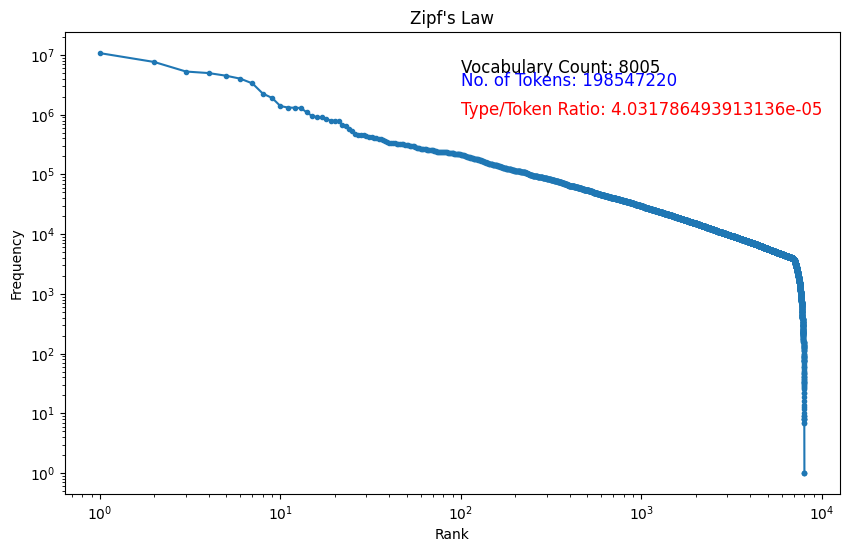

In [14]:
verify_zipfs_law(vocab_counter)

# Heap's Law

In [15]:
def fit_heaps_law(tokens_cumulative, vocab_cumulative):
    tokens_cumulative = np.array(tokens_cumulative)
    vocab_cumulative = np.array(vocab_cumulative)

    # Log-log transformation to fit Heap's Law
    logTokens = np.log(tokens_cumulative)
    logVocab = np.log(vocab_cumulative)

    # Fitting linear regression 
    coeffs = np.polyfit(logTokens, logVocab, deg=1)
    beta = coeffs[0]
    k = np.exp(coeffs[1])

    return k, beta

In [16]:
def heaps_law_analysis(tokens_cumulative, vocab_cumulative, k, beta):
    # Plotting Vocabulary Size against Token Size
    plt.scatter(tokens_cumulative, vocab_cumulative, alpha=0.5)
    plt.xlabel("Corpus Size")
    plt.ylabel("Vocabulary Size")

    # Plotting Heap's Line
    x = np.array(tokens_cumulative)
    y = k * (x ** beta)
    plt.plot(x,y, color = "red")

    # Logarithmic Scale for better visualization
    plt.xscale("log")
    plt.yscale("log")
    
    # Parameters
    plt.text(10000000,7920,f"\u03B2: {beta:.4f}", fontsize = 12, color = "black")
    plt.text(10000000,7900,f"K: {k:.4f}", fontsize = 12, color = "blue")

    plt.title("Heap's Law")
    plt.grid(True)
    plt.show()

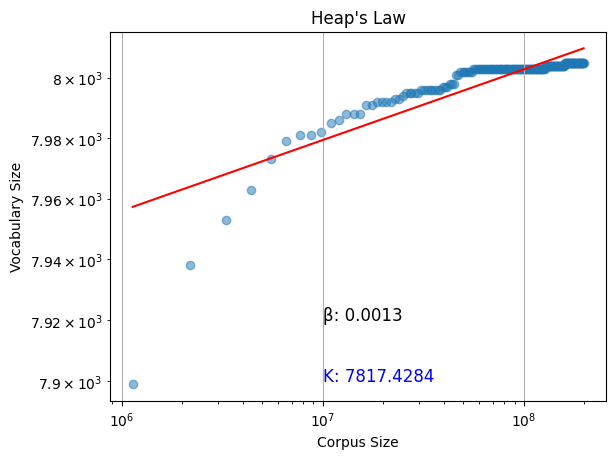

In [17]:
k, beta = fit_heaps_law(tokens_cumulative, vocab_cumulative)
heaps_law_analysis(tokens_cumulative, vocab_cumulative, k, beta)